Our goal

Predict various protein structures in cellular images

there are 28 different target proteins

multiple proteins can be present in one image (multilabel classification)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import tensorflow as tf
sns.set()

import os
print(os.listdir("../data"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Any results you write to the current directory are saved as output.

/home/watts/anaconda3/envs/hp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['train.zip', 'sample_submission.csv', 'command.txt', 'test', 'train', 'train.csv', 'cookies.txt']


In [2]:
train_labels = pd.read_csv("../data/train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [3]:
train_labels.shape

(31072, 2)

In [4]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [5]:
reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [6]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [7]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


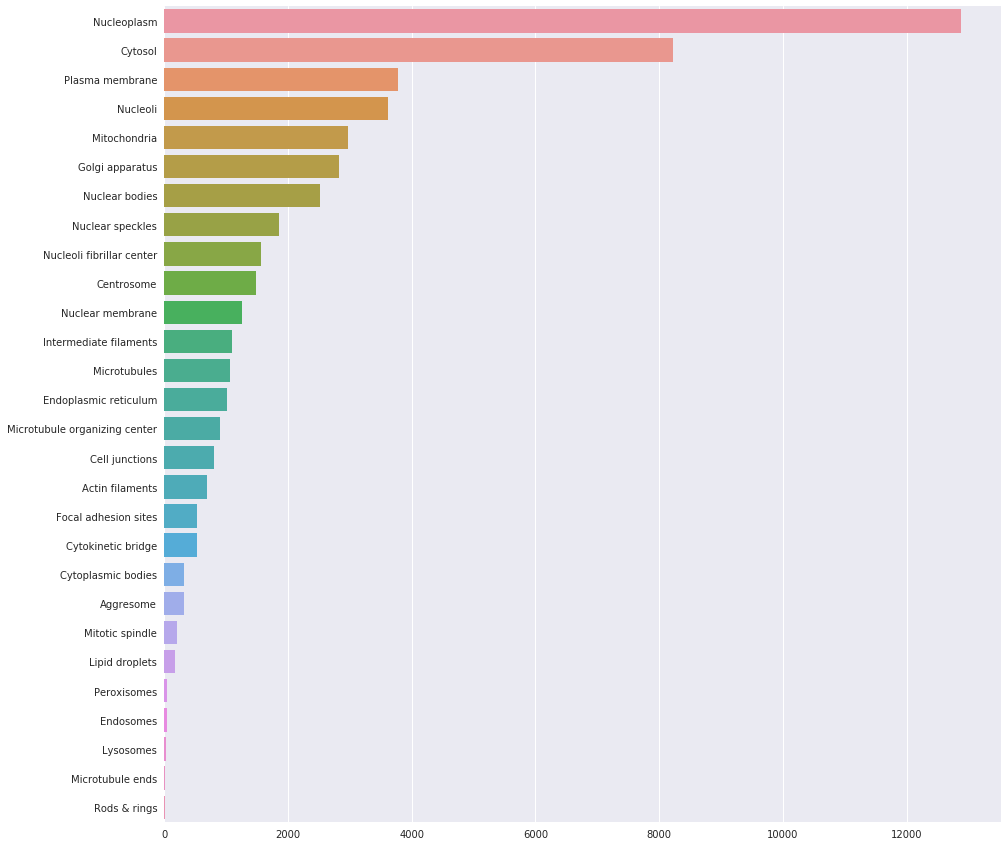

In [8]:
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

We can see that most common protein structures belong to coarse grained cellular components like the plasma membrane, the cytosol and the nucleus.

In contrast small components like the lipid droplets, peroxisomes, endosomes, lysosomes, microtubule ends, rods and rings are very seldom in our train data. For these classes the prediction will be very difficult as we have only a few examples that may not cover all variabilities and as our model probably will be confused during ins learning process by the major classes. Due to this confusion we will make less accurate predictions on the minor classes.

Consequently accuracy is not the right score here to measure your performance and validation strategy should be very fine.


# Most Common Target

Text(0,0.5,'% of data')

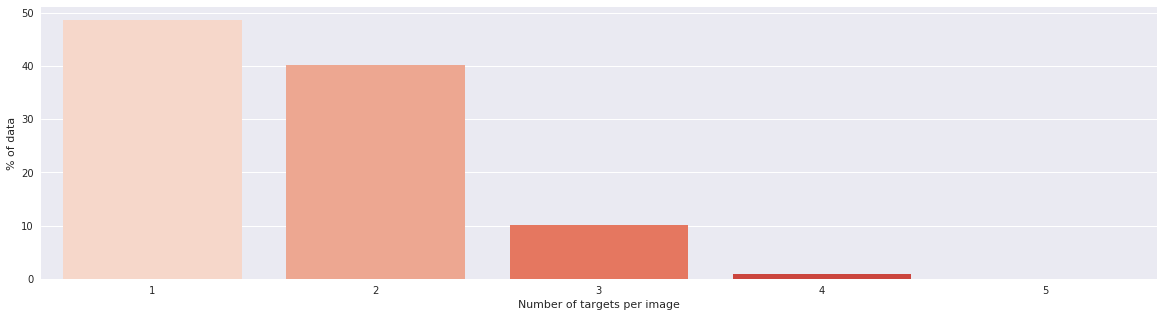

In [10]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * train_labels["number_of_targets"].value_counts() / train_labels.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")

Most train images only have 1 or two target labels.

More than 3 targets are very seldom!

# Which targets are correlated?



Let's see if we find some correlations between our targets. This way we may already see that some proteins often come together.

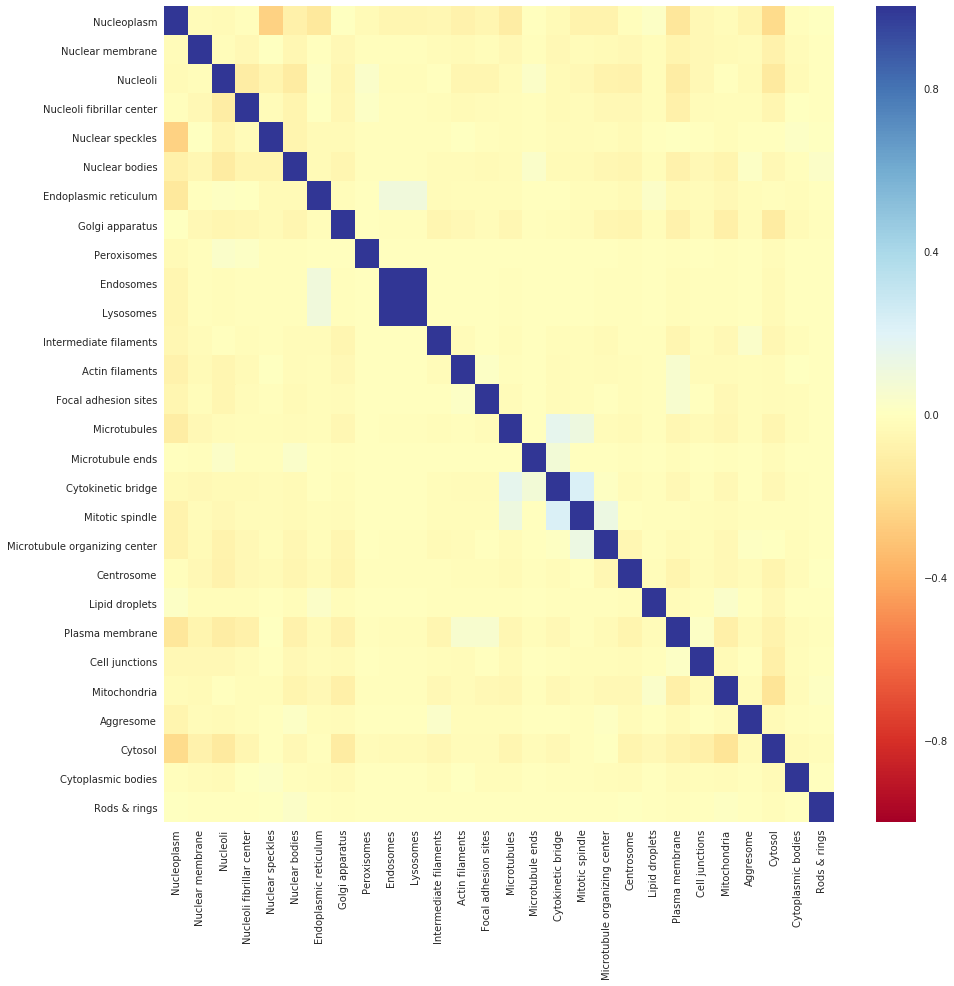

In [12]:
plt.figure(figsize=(15,15))
sns.heatmap(train_labels[train_labels.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

We can see that many targets only have very slight correlations.

In contrast, endosomes and lysosomes often occur together and sometimes seem to be located at the endoplasmatic reticulum.

In addition we find that the mitotic spindle often comes together with the cytokinetic bridge. This makes sense as both are participants for cellular division. And in this process microtubules and thier ends are active and participate as well. Consequently we find a positive correlation between these targets.

# How are special and seldom targets grouped?

Lysosomes and endosomes

Let's start with these high correlated features!

In [13]:
def find_counts(special_target, labels):
    counts = labels[labels[special_target] == 1].drop(
        ["Id", "Target", "number_of_targets"],axis=1
    ).sum(axis=0)
    counts = counts[counts > 0]
    counts = counts.sort_values()
    return counts

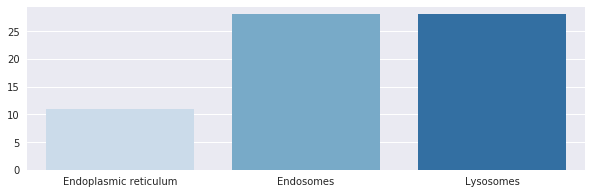

In [14]:
lyso_endo_counts = find_counts("Lysosomes", train_labels)

plt.figure(figsize=(10,3))
sns.barplot(x=lyso_endo_counts.index.values, y=lyso_endo_counts.values, palette="Blues")

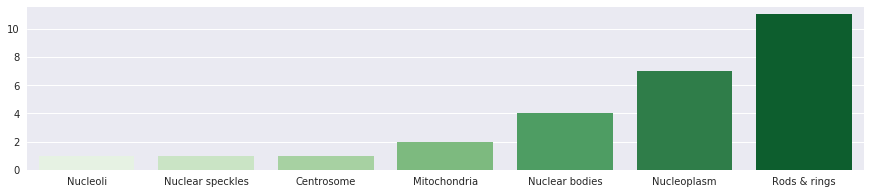

In [15]:
rod_rings_counts = find_counts("Rods & rings", train_labels)
plt.figure(figsize=(15,3))
sns.barplot(x=rod_rings_counts.index.values, y=rod_rings_counts.values, palette="Greens")

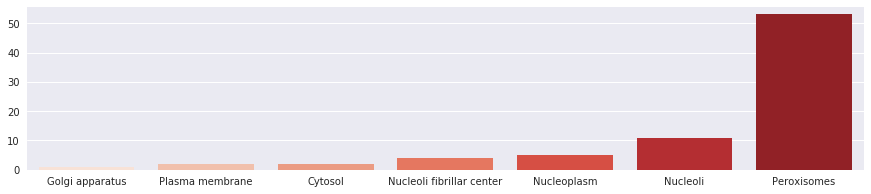

In [16]:
peroxi_counts = find_counts("Peroxisomes", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette="Reds")

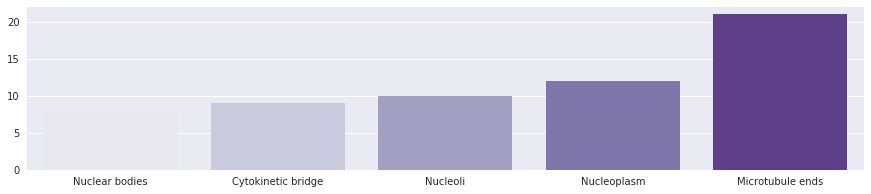

In [17]:
tubeends_counts = find_counts("Microtubule ends", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=tubeends_counts.index.values, y=tubeends_counts.values, palette="Purples")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

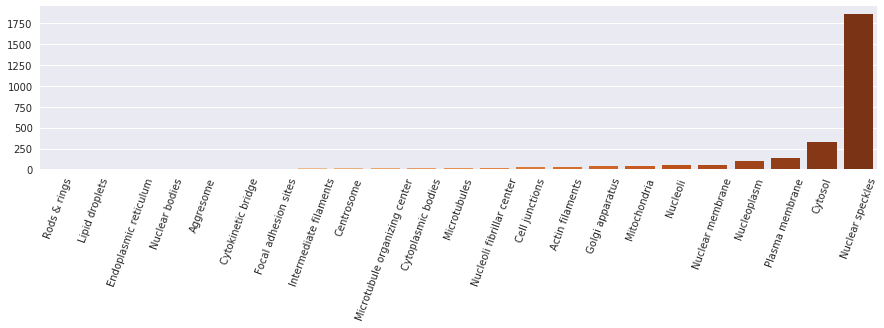

In [18]:
nuclear_speckles_counts = find_counts("Nuclear speckles", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=nuclear_speckles_counts.index.values, y=nuclear_speckles_counts.values, palette="Oranges")
plt.xticks(rotation="70")

We can see that even with very seldom targets we find some kind of grouping with other targets that reveal where the protein structure seems to be located.

For example, we can see that rods and rings have something to do with the nucleus whereas peroxisomes may be located in the nucleus as well as in the cytosol.

Perhaps this patterns might help to build a more robust model!

# How do the images look like?¶

Before we start loading images, let's have a look into the train directory to get an impression of what we can find there:

In [21]:
from os import listdir

files = listdir("../data/train")
for n in range(10):
    print(files[n])

16264ccc-bbc8-11e8-b2bc-ac1f6b6435d0_blue.png
3253924e-bbc1-11e8-b2bb-ac1f6b6435d0_blue.png
fef9703e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
61339ffa-bbc6-11e8-b2bc-ac1f6b6435d0_red.png
5f0e0266-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
b8c2d582-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
32c3c678-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
2b21c43e-bbab-11e8-b2ba-ac1f6b6435d0_green.png
824e48ac-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
7e26519e-bb9d-11e8-b2b9-ac1f6b6435d0_blue.png


Each image is actually splitted into 4 different image files.

These 4 files correspond to 4 different filter:
    
a green filter for the target protein structure of interest

blue landmark filter for the nucleus

red landmark filter for microtubules

yellow landmark filter for the endoplasmatic reticulum

Each image is of size 512 x 512

In [23]:
len(files)/4, len(files) / 4 == train_labels.shape[0]

(31072.0, True)

# How do images of specific targets look like?

In [24]:
train_path = "../data/train/"

In [25]:
def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_labels.loc[train_labels.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title


In [26]:
class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_train_labels[key] for key in target_names]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        train_labels["check_col"] = train_labels.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_labels[train_labels.check_col==1].Id.values
        train_labels.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(self.target_list).issuperset(set(targets)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images
            

Let's try to visualize specific target groups. In this example we will see images that contain the protein structures lysosomes or endosomes. Set target values of your choice and the target group iterator will collect all images that are subset of your choice:

In [27]:
your_choice = ["Lysosomes", "Endosomes"]
your_batch_size = 3

In [28]:
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

To keep the kernel dense, the target group iterator has a batch size which stands for the number of examples you like to look at once. In this example you can see a maximum amount of 3 images at one iteration. To observe the next 3 examples of your target group, just run the cell below again. This way you can run the cell until you have seen all images of your group without polluting the kernel:

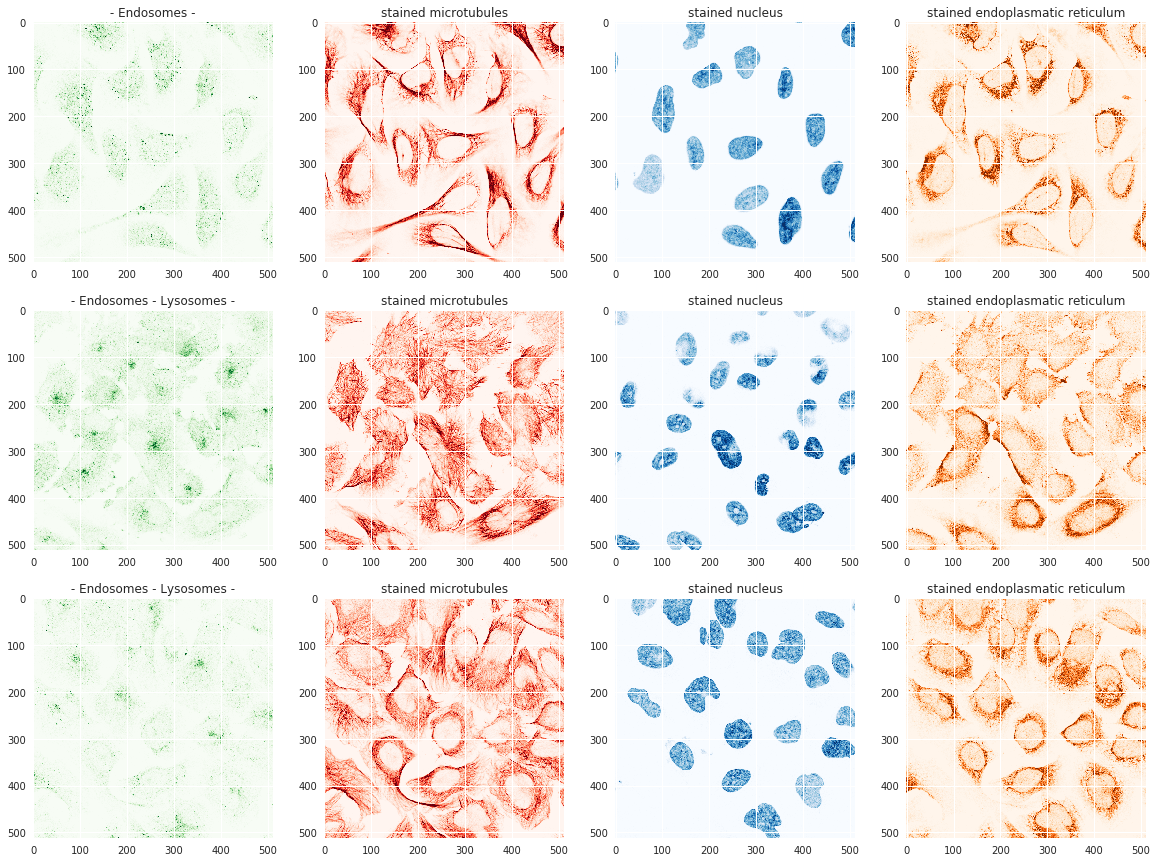

In [29]:
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

Looking at this few examples we can already obtain some insights:
The staining of target proteins in the green channel was not equally successful. The images differ in their intensities and the target proteins are not always located the same way. The first image you can get by the loader shows endosomes that are spread all over the cells and in the second and third you can find endosomes and lysosomes more concetrated around the nucleus.
Especially in the red channel we can see morphological differences. It looks like if the cells are of different types. This is just an assumption but perhaps one could use the red channel information to reveal cell types.